# **Feature Engineering**

## Objectives

* Create new features to improve model predictions.
* Transform and combine existing features.
* Explore the relationships between features and the target variable.

## Inputs

* Cleaned dataset: `outputs/datasets/collection/HousePricesRecords.csv`
* Data with handled missing values and correct data types.

## Outputs

* New dataset with engineered features: `outputs/datasets/feature_engineered/HousePricesFeatures.csv`
* Visualizations (if applicable): Charts showing feature relationships and distributions.


___

# Change working directory

We need to change the working directory from its current folder to its parent folder
* We access the current directory with os.getcwd()

In [1]:
import os
current_dir = os.getcwd()
current_dir

'/workspace/Heritage-Housing-Issues/jupyter_notebooks'

We want to make the parent of the current directory the new current directory
* os.path.dirname() gets the parent directory
* os.chir() defines the new current directory

In [2]:
os.chdir(os.path.dirname(current_dir))
print("You set a new current directory")

You set a new current directory


Confirm the new current directory

In [3]:
current_dir = os.getcwd()
current_dir

'/workspace/Heritage-Housing-Issues'

___

## Load data

In [1]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from feature_engine.selection import SmartCorrelatedSelection
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline

df = pd.read_csv("outputs/datasets/collection/HousePricesCleaned.csv")
print(df[['2ndFlrSF', 'BedroomAbvGr', 'SalePrice']].head())

   2ndFlrSF  BedroomAbvGr  SalePrice
0     854.0           3.0   208500.0
1       0.0           3.0   181500.0
2     866.0           3.0   223500.0
3       0.0           3.0   140000.0
4       0.0           4.0   250000.0


In [2]:
df.dtypes

1stFlrSF         float64
2ndFlrSF         float64
BedroomAbvGr     float64
BsmtExposure      object
BsmtFinSF1       float64
BsmtFinType1      object
BsmtUnfSF        float64
EnclosedPorch    float64
GarageArea       float64
GarageFinish      object
GarageYrBlt      float64
GrLivArea        float64
KitchenQual       object
LotArea          float64
LotFrontage      float64
MasVnrArea       float64
OpenPorchSF      float64
OverallCond        int64
OverallQual        int64
TotalBsmtSF      float64
WoodDeckSF       float64
YearBuilt          int64
YearRemodAdd       int64
SalePrice        float64
dtype: object

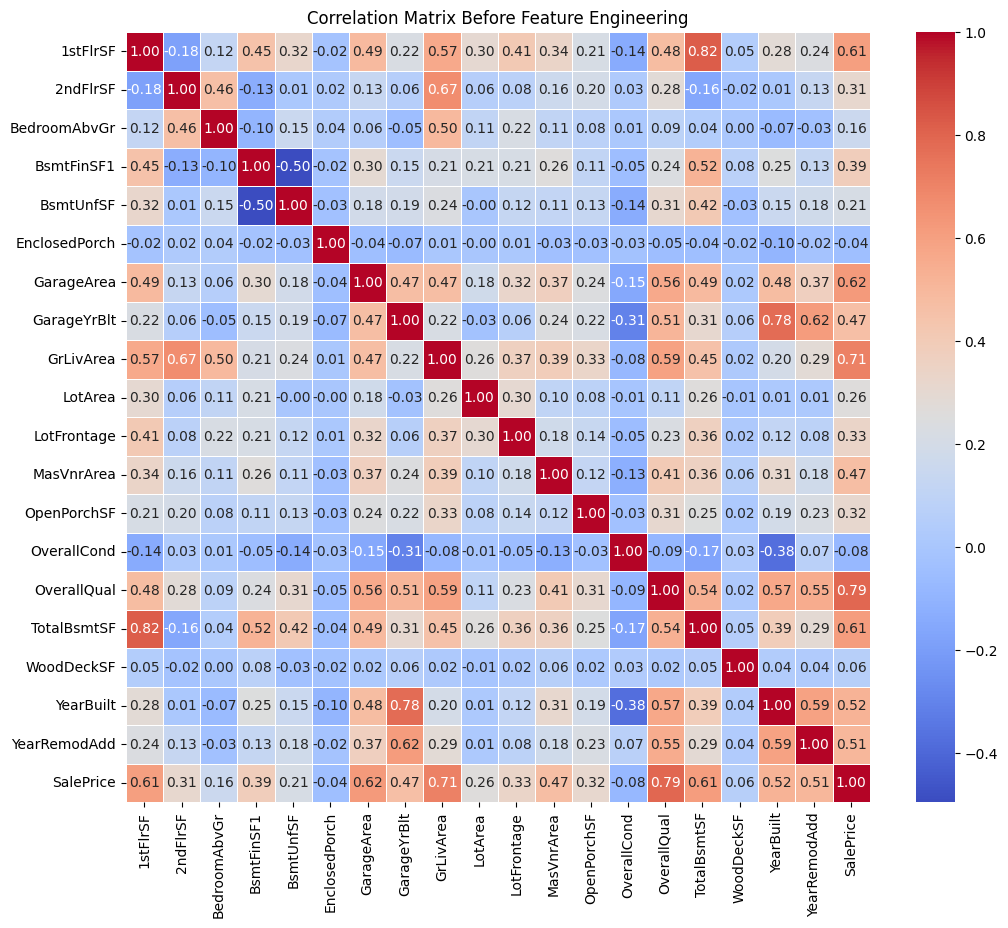

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt

# Show the correlation matrix before feature engineering
correlation_matrix_before = df.select_dtypes(include=['float64', 'int64']).corr()

plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix_before, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title("Correlation Matrix Before Feature Engineering")
plt.show()


**Correlation Matrix Before Feature Engineering**

The correlation matrix helps see how features relate to the target "SalePrice" before starting the feature engineering process. This helps decide which features are important and which can be combined or removed to make the model better.

Key Insights:

* **GrLivArea (0.71)** and **OverallQual (0.79)** have strong positive correalation to "SalePrice" making them important. New features could be created based on these to better capture house value.
* **GarageArea (0.62)** and **TotalBsmtSF (0.61)** also show strong correlations meaning bigger garages and basements add value. These could be combined into a "total storage" feature.
* Features like **EnclosedPorch (-0.04)** and **OverallCond (-0.08)** have weak links to "SalePrice". These may be improved, combined, or removed.

___

Plot the distribution of **2ndFlrSF** to see how many houses have a second floor and its size. This helps us understand if having a second floor affects the sale price or if there are any unusual patterns.

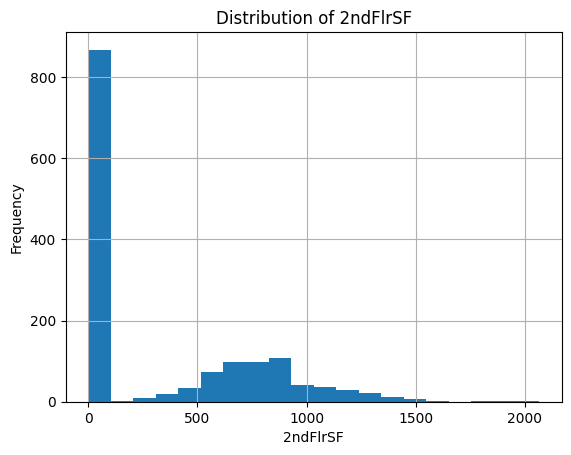

In [5]:
import matplotlib.pyplot as plt

df['2ndFlrSF'].hist(bins=20)
plt.title('Distribution of 2ndFlrSF')
plt.xlabel('2ndFlrSF')
plt.ylabel('Frequency')
plt.show()


**TotalSquareFootage** shows the total living space, including floors and basement.

In [9]:
# Create new features
df['TotalSquareFootage'] = df['1stFlrSF'] + df['2ndFlrSF'].fillna(0) + df['TotalBsmtSF'].fillna(0)

Plot **TotalSquareFootage** and **YearBuilt** against **SalePrice** to see if they are related. This helps us understand if house size and age affect the sale price.

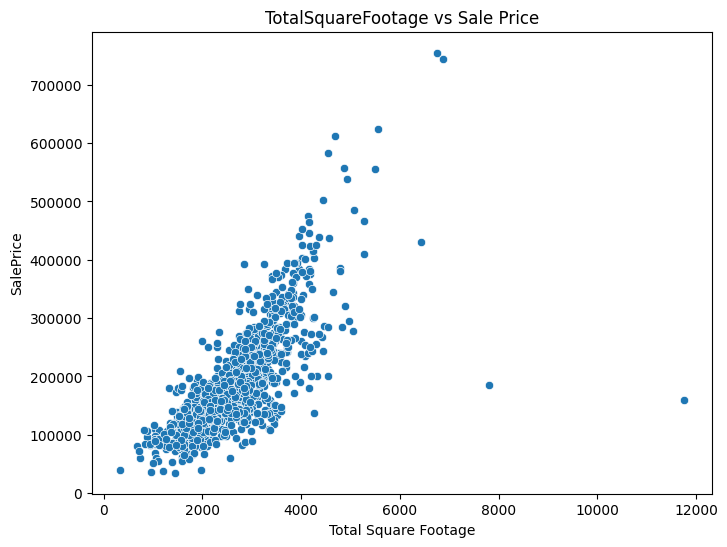

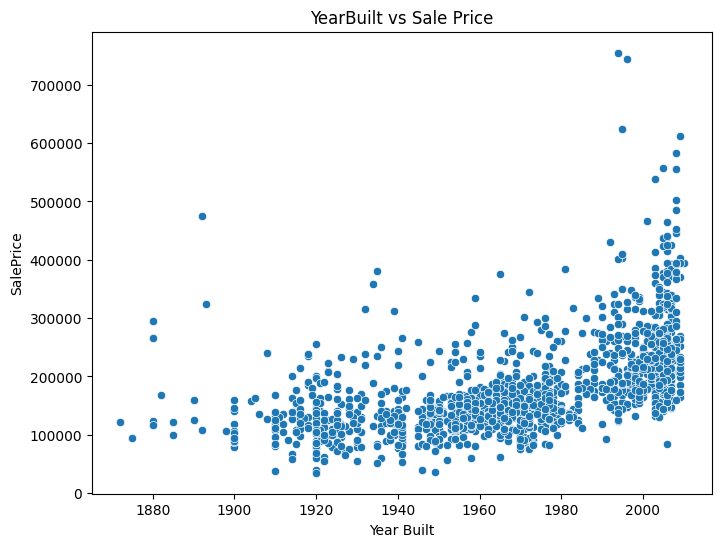

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt

# Visualize the correlation between TotalSquareFootage and SalePrice
plt.figure(figsize=(8, 6))
sns.scatterplot(x='TotalSquareFootage', y='SalePrice', data=df)
plt.xlabel('Total Square Footage')
plt.ylabel('SalePrice')
plt.title('TotalSquareFootage vs Sale Price')
plt.show()

# Visualize the correlation between HouseAge and SalePrice
plt.figure(figsize=(8, 6))
sns.scatterplot(x='YearBuilt', y='SalePrice', data=df)
plt.xlabel('Year Built')
plt.ylabel('SalePrice')
plt.title('YearBuilt vs Sale Price')
plt.show()



* The scatter plot shows a strong positive relationship between total square footage and sale price, as expected. Larger houses usually have higher sale prices. This confirms that total living space is an important predictor of house value, and including this feature should help improve model accuracy.
* The scatter plot shows that older houses (100 years) tend to have lower sale prices, while newer houses sell for more. This suggests that house age has a some effect on property value.

___

* **Encode categorical variables:** Turn category columns into numbers so the model can use them.
* **Boolean columns:** Change True/False to 0 and 1 for the model.
* **Separate columns:** Split numeric and category columns to handle them better, like scaling numbers.

In [15]:
# Categorical and numerical columns
categorical_columns = ['BsmtExposure', 'BsmtFinType1', 'GarageFinish', 'KitchenQual']
numerical_columns = ['2ndFlrSF', 'BedroomAbvGr', 'BsmtFinSF1', 'GarageArea', 'GrLivArea', 'TotalSquareFootage']

# Select numerical data
X_numerical = df[numerical_columns]

# Used one-hot encoding for categories
X_categorical = df[categorical_columns]
X_categorical_encoded = pd.get_dummies(X_categorical)

# Changed boolean columns to 0 and 1
X_categorical_encoded = X_categorical_encoded.astype(int)

* Combine columns to put all the numeric and encoded category columns together in one dataset.
* Scale numbers to make all numeric values similar in range to help the model work better.

In [16]:
# Combined numbers and encoded categories
X_combined = pd.concat([X_numerical, X_categorical_encoded], axis=1)

# Create a pipeline to scale numbers
pipeline = Pipeline([
    ('scaler', StandardScaler())
])


* Scale the numeric features so they are all on a similar range.
* Add 'SalePrice' to the transformed dataset.
* Print the dataset size, first few rows, and data types after transformation.
* Print an error message if something goes wrong.

In [17]:
try:
    # Scale numerical features using the pipeline
    X_combined[numerical_columns] = pipeline.fit_transform(X_combined[numerical_columns])

    # Include SalePrice in the transformed dataset
    X_combined['SalePrice'] = df['SalePrice']

    # Display information about the transformed dataset
    print("Transformed dataset size:", X_combined.shape)
    print(X_combined.head())
    print(X_combined.dtypes)

except Exception as e:
    print("Error during pipeline execution:", e)

Transformed dataset size: (1460, 24)
   2ndFlrSF  BedroomAbvGr  BsmtFinSF1  GarageArea  GrLivArea  \
0  1.213595      0.153895    0.575425    0.351000   0.370333   
1 -0.756746      0.153895    1.171992   -0.060731  -0.482512   
2  1.241281      0.153895    0.092907    0.631726   0.515013   
3 -0.756746      0.153895   -0.499274    0.790804   0.383659   
4 -0.756746      1.416182    0.463568    1.698485   1.299326   

   TotalSquareFootage  BsmtExposure_Av  BsmtExposure_Gd  BsmtExposure_Mn  \
0            0.021700                0                0                0   
1           -0.029076                0                1                0   
2            0.190955                0                0                1   
3           -1.004708                0                0                0   
4           -0.311973                1                0                0   

   BsmtExposure_No  ...  BsmtFinType1_Rec  BsmtFinType1_Unf  GarageFinish_Fin  \
0                1  ...                 

Check for missing values after one-hot encoding

In [18]:
missing_values_after_encoding = X_categorical_encoded.isnull().sum()
print("Missing values after one-hot encoding:")
print(missing_values_after_encoding[missing_values_after_encoding > 0])

Missing values after one-hot encoding:
Series([], dtype: int64)


 No missing values found in categorical columns after one-hot encoding

___

In [19]:
print("Missing values in numerical columns:")
print(df[numerical_columns].isnull().sum())

Missing values in numerical columns:
2ndFlrSF              0
BedroomAbvGr          0
BsmtFinSF1            0
GarageArea            0
GrLivArea             0
TotalSquareFootage    0
dtype: int64


In [20]:
print("DataFrame shape after operation:", df.shape)
print("DataFrame columns after operation:", df.columns.tolist())

DataFrame shape after operation: (1460, 26)
DataFrame columns after operation: ['1stFlrSF', '2ndFlrSF', 'BedroomAbvGr', 'BsmtExposure', 'BsmtFinSF1', 'BsmtFinType1', 'BsmtUnfSF', 'EnclosedPorch', 'GarageArea', 'GarageFinish', 'GarageYrBlt', 'GrLivArea', 'KitchenQual', 'LotArea', 'LotFrontage', 'MasVnrArea', 'OpenPorchSF', 'OverallCond', 'OverallQual', 'TotalBsmtSF', 'WoodDeckSF', 'YearBuilt', 'YearRemodAdd', 'SalePrice', 'TotalSquareFootage', 'Quality_Year_Category']


Show correlation matrix for numeric features

In [21]:
correlation_matrix = df.select_dtypes(include=['float64', 'int64']).corr()

Create a **heatmap** to visualize the correlation matrix **after** Feature Engineering

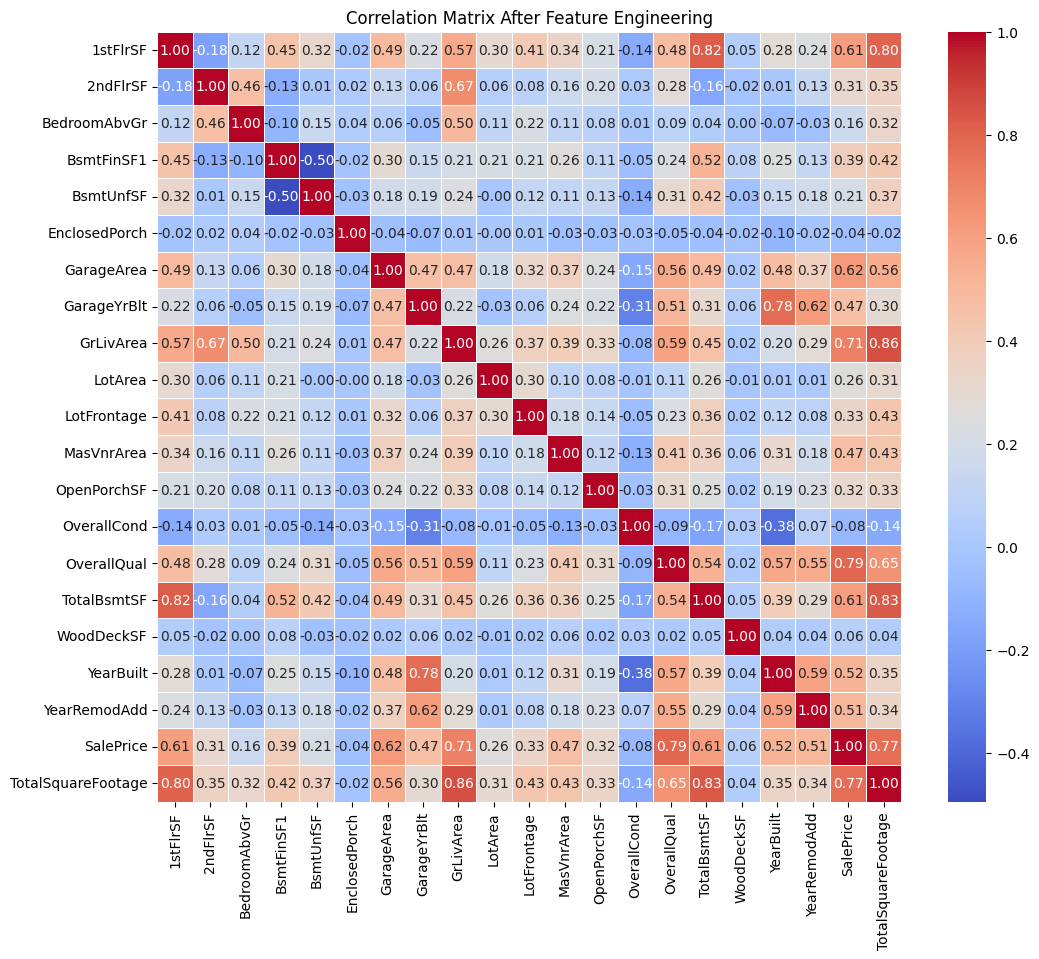

In [22]:

correlation_matrix_after = df.select_dtypes(include=['float64', 'int64']).corr()

plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix_after, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title("Correlation Matrix After Feature Engineering")
plt.show()



**Correlation Matrix After Feature Engineering**

The updated correlation matrix shows the impact of feature engineering:

* **TotalSquareFootage (0.77)** has a strong positive correlation with SalePrice. Combining multiple area features into one makes it easier for the model to understand how the house's overall size adds value.
* **OverallCond (-0.08)** has a weak correlation with SalePrice, indicating that the overall condition of the house does not significantly impact its sale price. This feature might be less useful for the model.
* **GrLivArea (0.71)** and **OverallQual (0.79)** still have strong correlations with SalePrice, showing they are still important for predicting house prices.
The goal was to create features that better represent the relationship with SalePrice and reduce redundancy. Features like TotalSquareFootage help improve model predictions by combining related variables.

___

This matrix helps visualize which features are strongly correlated with "SalePrice". Focusing on these features leads to more effective model training and better performance.

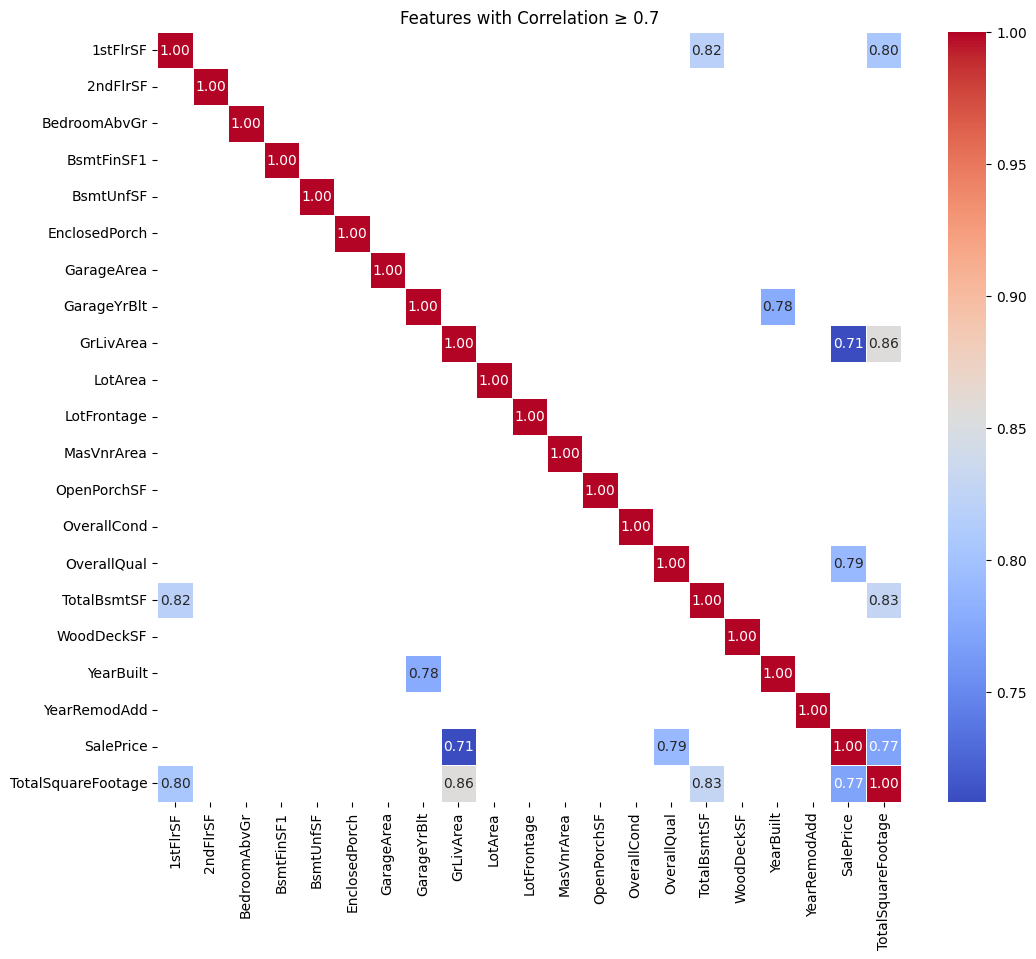

In [23]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Threshold for high correlation
threshold = 0.7

# Filter correlation matrix to keep values >= 0.7
high_correlation = correlation_matrix.applymap(lambda x: x if x >= threshold else np.nan)

# Plot the filtered correlation matrix
plt.figure(figsize=(12, 10))
sns.heatmap(high_correlation, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5, cbar=True)
plt.title("Features with Correlation ≥ 0.7")
plt.show()


In [24]:
# Filter high correlation features related to SalePrice
high_corr_with_target = correlation_matrix['SalePrice'][correlation_matrix['SalePrice'] >= threshold]
print("Features with high correlation to SalePrice:", high_corr_with_target)

Features with high correlation to SalePrice: GrLivArea             0.708624
OverallQual           0.790982
SalePrice             1.000000
TotalSquareFootage    0.772116
Name: SalePrice, dtype: float64


### Hypothesis 1 Confirmed
The scatter plots and correlation analysis show a positive relationship between the total area of the house and its sale price, confirming the initial hypothesis that bigger houses tend to have higher sale prices.

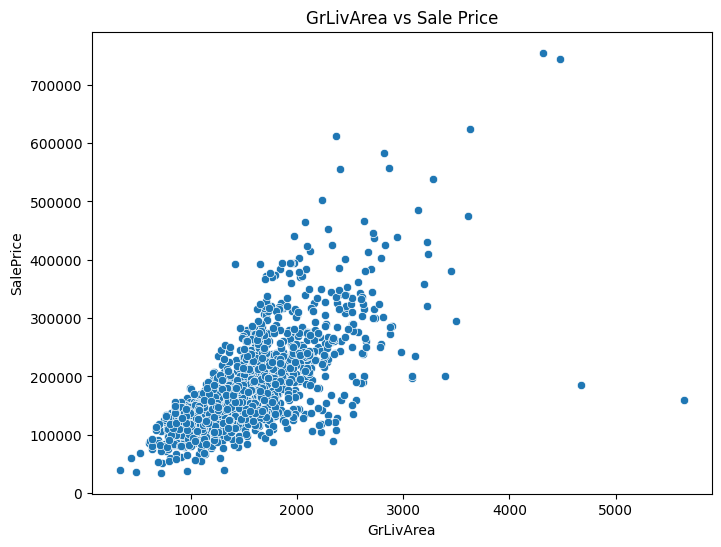

In [25]:
plt.figure(figsize=(8, 6))
sns.scatterplot(x='GrLivArea', y='SalePrice', data=df)
plt.xlabel('GrLivArea')
plt.ylabel('SalePrice')
plt.title('GrLivArea vs Sale Price')
plt.show()

### Hypothesis 2 Confirmed
* The scatter plot and correlation analysis show a strong positive link between OverallQual and SalePrice. With a correlation of 0.79, higher quality homes tend to sell for more. This confirms that home quality affects its sale price.

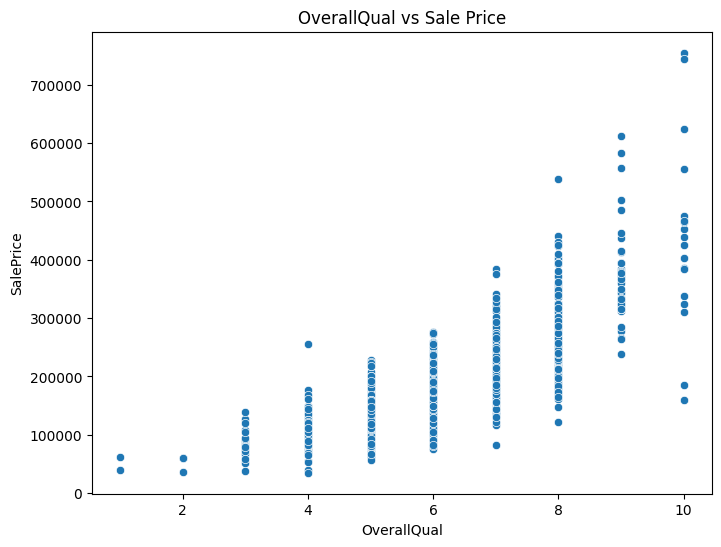

In [26]:
plt.figure(figsize=(8, 6))
sns.scatterplot(x='OverallQual', y='SalePrice', data=df)
plt.xlabel('OverallQual')
plt.ylabel('SalePrice')
plt.title('OverallQual vs Sale Price')
plt.show()

### Hypothesis 3 Confirmed
The scatter plot and correlation analysis show a positive relationship between 'GarageArea' and 'SalePrice'. This confirms the hypothesis that houses with bigger garages tend to sell for higher prices.

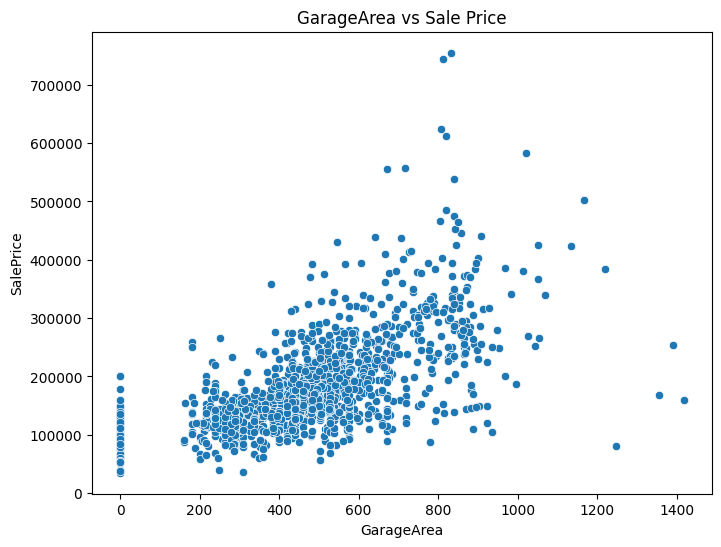

In [27]:
plt.figure(figsize=(8, 6))
sns.scatterplot(x='GarageArea', y='SalePrice', data=df)
plt.xlabel('GarageArea')
plt.ylabel('SalePrice')
plt.title('GarageArea vs Sale Price')
plt.show()

In [28]:
print(X_combined.dtypes)

2ndFlrSF              float64
BedroomAbvGr          float64
BsmtFinSF1            float64
GarageArea            float64
GrLivArea             float64
TotalSquareFootage    float64
BsmtExposure_Av         int64
BsmtExposure_Gd         int64
BsmtExposure_Mn         int64
BsmtExposure_No         int64
BsmtFinType1_ALQ        int64
BsmtFinType1_BLQ        int64
BsmtFinType1_GLQ        int64
BsmtFinType1_LwQ        int64
BsmtFinType1_Rec        int64
BsmtFinType1_Unf        int64
GarageFinish_Fin        int64
GarageFinish_RFn        int64
GarageFinish_Unf        int64
KitchenQual_Ex          int64
KitchenQual_Fa          int64
KitchenQual_Gd          int64
KitchenQual_TA          int64
SalePrice             float64
dtype: object


Print the number of unique values in each column

In [29]:
print(df.nunique())
print(df['SalePrice'].unique())

1stFlrSF                  753
2ndFlrSF                  401
BedroomAbvGr                8
BsmtExposure                4
BsmtFinSF1                637
BsmtFinType1                6
BsmtUnfSF                 780
EnclosedPorch              19
GarageArea                441
GarageFinish                3
GarageYrBlt                97
GrLivArea                 861
KitchenQual                 4
LotArea                  1073
LotFrontage               110
MasVnrArea                327
OpenPorchSF               202
OverallCond                 9
OverallQual                10
TotalBsmtSF               721
WoodDeckSF                 58
YearBuilt                 112
YearRemodAdd               61
SalePrice                 663
TotalSquareFootage        964
Quality_Year_Category       4
dtype: int64
[208500. 181500. 223500. 140000. 250000. 143000. 307000. 200000. 129900.
 118000. 129500. 345000. 144000. 279500. 157000. 132000. 149000.  90000.
 159000. 139000. 325300. 139400. 230000. 154000. 256300. 1348

___

## Push files to repo

In [30]:
X_combined.to_csv("outputs/datasets/collection/HousePricesFeatures.csv", index=False)
print("Exported the transformed dataset successfully!")

Exported the transformed dataset successfully!


### Feature Engineering Summary

* In this notebook new features like TotalSquareFootage and HouseAge to improve predictions was created. 
* Before adding new features, GrLivArea and OverallQual had the highest correlation with SalePrice. After adding TotalSquareFootage and HouseAge, both showed strong relationships with SalePrice, helping improve model predictions.
* Visualizations confirmed their impact on SalePrice. 
* Features were normalized, one-hot encoded, and checked for missing values. 
* Hypothesis 1, 2 and 3 were confirmed. Noted in README.
* Final dataset is ready for modeling.